In [1]:
import numpy as np
import scipy
from collections import Counter
import re

from nlp import Tokenizer, TfIdf

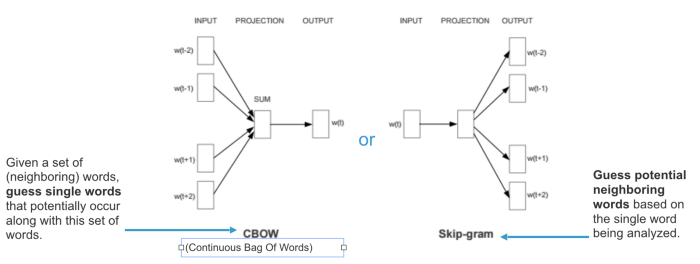

In [746]:
class Word2Vec:
    def __init__(self):
        self.embedding_size = None
        self.corpus = []
        self.counts = {}
        self.idx2token = {}
        self.token2idx = {}
        self.W0 = None
        self.W1 = None
    
    def collect_train(self, data, window_size):
        # CBOW
        X = []
        y = []
        v_len = len(self.corpus)
        for row in data:
            for i in range(len(row)):
                word = np.zeros((1, v_len))
                word[0, self.token2idx[row[i]]] = 1
                
                target = np.zeros((1, v_len))
                
                for j in range(1, window_size + 1):
                    if 0 <= i - j < len(row):
                        target[0, self.token2idx[row[i - j]]] = 1
                    if 0 <= i + j < len(row):
                        target[0, self.token2idx[row[i + j]]] = 1
                        
                X.append(word)
                y.append(target)
        
        X = np.vstack(X)
        y = np.vstack(y)
        return X, y
        
    
    def fit(self, X, embedding_size=128, window_size=5, epochs=10, lr=0.1):
        self.embedding_size = embedding_size
        # collect statistics
        for row in X:
            self.corpus.extend(row)
            
        self.counts = dict(Counter(self.corpus))
        self.corpus = list(set(self.corpus))
        
        for i, token in enumerate(self.corpus):
            self.idx2token[i] = token
            self.token2idx[token] = i
            
        # here we go
        X, y = self.collect_train(X, window_size)

        # X * W0 = hidden
        # hidden * W1 = output
        # softmax(output) = prediction 
        self.W0 = np.random.uniform(0.1, size=(len(self.corpus), self.embedding_size))
        self.W1 = np.random.uniform(0.1, size=(self.embedding_size, len(self.corpus)))
        
        for e in range(epochs):
            self.loss = 0
            y_pred, raw, hidden = self.forward(X)


            err = np.subtract(y_pred, y)
            
            dW1 = np.dot(err.T, hidden).T
            dW0 = np.dot(X.T, np.dot(err, dW1.T))
            self.W1 += lr * dW1
            self.W0 += lr * dW0

            loss = np.sum(err)
            print(np.isnan(self.W0).any())
            print(np.isnan(self.W1).any())
            print(f"Epoch {e}: loss {loss}")
#             dl_dw2 = np.outer(h, e)
#     # x - shape 1x8, w2 - 5x8, e.T - 8x1
#     # x - 1x8, np.dot() - 5x1, dl_dw1 - 8x5
#     dl_dw1 = np.outer(x, np.dot(self.w2, e.T))
#     # Update weights
#     self.w1 = self.w1 - (self.lr * dl_dw1)
#     self.w2 = self.w2 - (self.lr * dl_dw2)
            
    def forward(self, X):
        hidden = np.dot(X, self.W0)
        raw = np.dot(hidden, self.W1)
        pred = self.softmax(raw)
        return pred, raw, hidden

    def softmax(self, x):
        e_x = np.exp(x)
        return e_x / e_x.sum(axis=1).reshape(-1, 1)
    
    def _check_trained(self):
        if self.W0 is None:
            raise Exception('Estimator is not fitted')
    
    def predict_string(self, X):
        self._check_trained()
        if X in self.corpus:
            return self.W0[self.token2idx[X]]
        else:
            return None
            
    def predict(self, X):
        self._check_trained()
        if isinstance(X, str):
            return self.predict_string(X)
        if isinstance(X, list) or isinstance(X, tuple):
            return [self.predict_string(w) for w in X]
        
    def context_words(self, w, n=5):
        self._check_trained()
        curr = self.predict_string(w)
        # find nearest vectors
        
    def nearest_words(self, w):
        self._check_trained()
        arr = np.zeros(1, len(self.corpus))
        arr[token2idx[w]] = 1
        pred, _, _ = self.forward(arr)
        # find top N words, return {word: probability}
    
    def save(self, path):
        pass
    
    def load(self, path):
        pass

In [747]:
X = ['ab bc cd', 'ab bc de bc', 'bc de ef fg']

In [748]:
t = Tokenizer()
X_tok = t(X)

In [749]:
w2v = Word2Vec()

In [750]:
w2v.fit(X_tok, window_size=2, lr=10)

False
False
Epoch 0: loss -14.0
True
True
Epoch 1: loss nan
True
True
Epoch 2: loss nan
True
True
Epoch 3: loss nan
True
True
Epoch 4: loss nan
True
True
Epoch 5: loss nan
True
True
Epoch 6: loss nan
True
True
Epoch 7: loss nan
True
True
Epoch 8: loss nan
True
True
Epoch 9: loss nan


/tmp/ipykernel_26592/4201982240.py:90: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x)
/tmp/ipykernel_26592/4201982240.py:91: RuntimeWarning: invalid value encountered in true_divide
  return e_x / e_x.sum(axis=1).reshape(-1, 1)


In [434]:
tfidf = TfIdf()
tfidf.fit(X_tok)

result = tfidf.transform(X_tok)
print(result.todense())

[[ 0.44544895 -0.31605106  0.          1.20694896  0.          0.        ]
 [ 0.56209399 -0.19940602  0.          0.          0.          0.56209399]
 [ 0.         -0.39881203  1.52300002  0.          1.52300002  0.56209399]]


In [435]:
tfidf.transform(t(['ab bc fg ge'])).todense()

matrix([[ 0.56209399, -0.39881203,  0.        ,  0.        ,  1.52300002,
          0.        ]])

In [436]:
tfidf.save('state.npy')

In [437]:
tfidf = TfIdf()
tfidf.load('state.npy')


In [438]:
result = tfidf.transform(X_tok)
print(result.todense())

[[ 0.44544895 -0.31605106  0.          1.20694896  0.          0.        ]
 [ 0.56209399 -0.19940602  0.          0.          0.          0.56209399]
 [ 0.         -0.39881203  1.52300002  0.          1.52300002  0.56209399]]


In [439]:
tfidf.corpus

['ab', 'bc', 'ef', 'cd', 'fg', 'de']

In [440]:
sklearn_tfidf = TfidfVectorizer(stop_words=None)
sklearn_tfidf.fit_transform(X).todense()

matrix([[0.54783215, 0.42544054, 0.72033345, 0.        , 0.        ,
         0.        ],
        [0.47606294, 0.73941068, 0.        , 0.47606294, 0.        ,
         0.        ],
        [0.        , 0.34520502, 0.        , 0.44451431, 0.5844829 ,
         0.5844829 ]])

In [441]:
sklearn_tfidf.transform(['ab bc fg ge']).todense()

matrix([[0.54783215, 0.42544054, 0.        , 0.        , 0.        ,
         0.72033345]])

In [392]:
sklearn_tfidf.idf_

array([1.28768207, 1.        , 1.69314718, 1.28768207, 1.69314718,
       1.69314718])

In [393]:
tfidf.IDF

{'ab': 0.4054651081081644,
 'bc': -0.2876820724517809,
 'ef': 1.0986122886681098,
 'cd': 1.0986122886681098,
 'fg': 1.0986122886681098,
 'de': 0.4054651081081644}

In [216]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
twenty_train = fetch_20newsgroups()

In [97]:
twenty_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [98]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [99]:
import pandas
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

news = datasets.fetch_20newsgroups(subset='all', categories=['alt.atheism', 'sci.space'])
data = news.data
target = news.target

tfidf = TfidfVectorizer()
data_transformed = tfidf.fit_transform(data)



In [100]:
data_transformed.shape

(1786, 28382)

In [ ]:
grid = {'C': np.power(10.0, np.arange(-5, 6))}
kf = KFold(n_splits = 5, shuffle = True, random_state = 241)
svm = SVC(kernel = 'linear', random_state=241)
gs = GridSearchCV(svm, grid, scoring = 'accuracy', cv = kf)
gs.fit(data_transformed, target)

C = gs.best_params_.get('C')
svm = SVC(kernel = 'linear', random_state=241, C=C)
svm.fit(data_transformed, target)

coef = svm.coef_
features = tfidf.get_feature_names()
words = pandas.concat([abs(pandas.DataFrame(coef.toarray()).transpose()), pandas.DataFrame(features)], axis = 1, ignore_index = True)
words = words.sort_values(by = [0], ascending = False)
top = words[[1]][:10]
print(top.sort_values(by=[1]).reset_index(drop=True))